# Landmark Detection with Machine Learning 

In [1]:
import matplotlib.pyplot as plt

from PIL import Image

from random import randint

import pandas as pd

import numpy as np

from tqdm import tqdm

import urllib
import cv2
import plotly.express as px

In [2]:
import torch
import torchvision

import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [4]:


# loading train data
df_train = pd.read_csv('train1.csv')
print(df_train.head())

df_boxes_split1 = pd.read_csv('boxes_split1.csv')
df_boxes_split2 = pd.read_csv('boxes_split2.csv')
df_boxes = pd.concat([df_boxes_split1, df_boxes_split2])

print(df_boxes.head())

                 id                                                url  \
0  97c0a12e07ae8dd5  http://lh4.ggpht.com/-f8xYA5l4apw/RSziSQVaABI/...   
1  650c989dd3493748  https://lh5.googleusercontent.com/-PUnMrX7oOyA...   
2  05e63ca9b2cde1f4  http://mw2.google.com/mw-panoramio/photos/medi...   
3  08672eddcb2b7c93  http://lh3.ggpht.com/-9fgSxDYwhHA/SMvGEoltKTI/...   
4  fc49cb32ef7f1e89  http://lh6.ggpht.com/-UGAXxvPbr98/S-jGZbyMIPI/...   

  landmark_id  
0        6347  
1       12519  
2         264  
3       13287  
4        4018  
                 id                  box
0  03b4355b047c94b4  0.12 0.16 0.74 1.00
1  435986fb31b5f4f3  0.37 0.35 0.52 0.40
2  a8e1490b5f8d37e2  0.22 0.00 0.87 1.00
3  1078a00bdf260dad  0.10 0.00 0.70 1.00
4  6335ea2d8c6a995a  0.19 0.26 0.94 0.88


In [5]:
df_train = pd.merge(df_train, df_boxes, on='id',  how='right')
df_train.head()

,id,url,landmark_id,box
0,03b4355b047c94b4,http://lh4.ggpht.com/-AVHZIuVDEFw/SHIL1hcD6YI/...,11072,0.12 0.16 0.74 1.00
1,435986fb31b5f4f3,https://lh5.googleusercontent.com/-bn7BRaI_LmU...,5614,0.37 0.35 0.52 0.40
2,a8e1490b5f8d37e2,http://lh3.ggpht.com/-180LkbBxnT8/RvUGNtUXXAI/...,2866,0.22 0.00 0.87 1.00
3,1078a00bdf260dad,https://lh5.googleusercontent.com/-8mEyd9zB6Uk...,1894,0.10 0.00 0.70 1.00
4,6335ea2d8c6a995a,http://mw2.google.com/mw-panoramio/photos/medi...,5752,0.19 0.26 0.94 0.88


In [6]:
import pandas as pd
import numpy as np
import csv

train_df = pd.read_csv("train1.csv")
test_df = pd.read_csv("test.csv")
submission = pd.read_csv("./sample_submission.csv")

## EDA of Dataset

In [7]:
### Get top 100 most frequently appearing landmark_id from the original dataset

In [8]:
rank_number = 100 # Number of top most frequent landmark_id for image selection
sampling_rate = 0.02 # fraction of images from each landmark_id
random_state = 17 # for reproducibility

landmarks=train_df.groupby(by='landmark_id').count().loc[:,'id']
l = landmarks.sort_values(ascending=False)

#l=landmarks.sample(frac=1,random_state=random_state)
lmks = pd.concat([l, l/l.sum(), l.cumsum()/l.sum()], axis=1, ignore_index=True)
lmks.columns=['Count', 'Proportion', 'CumSum']
ranked = lmks[0:rank_number]

train_ordered = train_df[train_df.landmark_id.isin(ranked.index)]
sample_gby = train_ordered.groupby(by='landmark_id').apply(lambda x: x.sample(frac=sampling_rate, random_state=random_state))
sample_idx = sample_gby.index.levels[1]
train_sample = train_df.iloc[sample_idx, :]

# write to csv file
train_sample.to_csv('train_sample.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
train_sample_df = pd.read_csv('train_sample.csv')

In [9]:
train_sample.head()

,id,url,landmark_id
48,0b7ca98b7ff8c0cd,https://lh6.googleusercontent.com/-jCiqpASe2Sk...,6696
61,c748cec517ba5aa4,http://lh4.ggpht.com/-YzuWuieyLyg/S6G2Lyrv8VI/...,6651
77,0e93f2388ca6fe45,http://lh4.ggpht.com/-vyK23KRCis4/T7T_YFZ3rQI/...,5376
150,376ceaec60118136,https://lh3.googleusercontent.com/-LQnSgukyc84...,5046
345,186f304309ea56b7,https://lh5.googleusercontent.com/-1PmqYO7TznA...,9779


In [10]:
print("Total training data size:", train_df.shape[0])
print("Total test data size:", test_df.shape[0])
print("Total number of unique landmark_id's:", len(landmarks))

print("Sampled training data size:", train_sample.shape[0])
print("Sampled unique landmark_id's:", len(train_sample["landmark_id"].unique()))

Total training data size: 1225029
Total test data size: 117577
Total number of unique landmark_id's: 14945
Sampled training data size: 9134
Sampled unique landmark_id's: 100


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [12]:
### Frequency of landmark_id in dataset

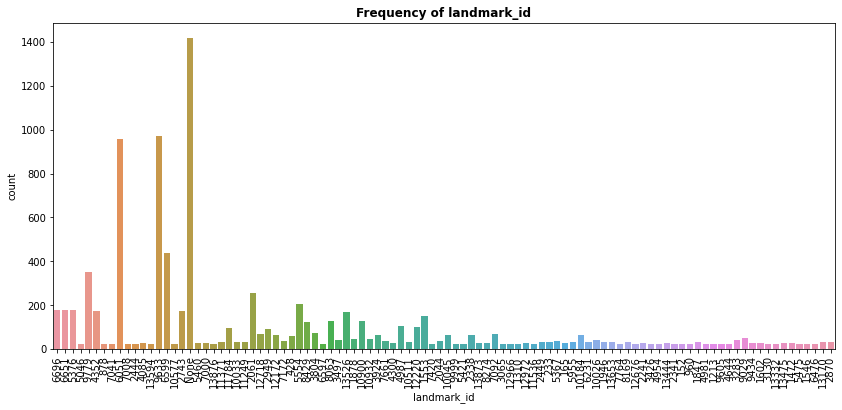

In [13]:
plt.figure(figsize = (14, 6))
g = sns.countplot(x="landmark_id", data=train_sample)
g.set_title("Frequency of landmark_id", fontweight="bold", fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [14]:
# Top 10 frequent landmark_ids

train_sample['landmark_id'].value_counts()[:10]

None    1417
9633     971
6051     956
6599     436
9779     352
2061     255
5554     206
6651     179
6696     178
5376     178
Name: landmark_id, dtype: int64

In [15]:
train_sample.nunique()

id             9134
url            7718
landmark_id     100
dtype: int64

In [16]:
landmark_dist = train_sample['landmark_id'].value_counts() / train_sample.shape[0]
landmark_dist.head()

None    0.155135
9633    0.106306
6051    0.104664
6599    0.047734
9779    0.038537
Name: landmark_id, dtype: float64

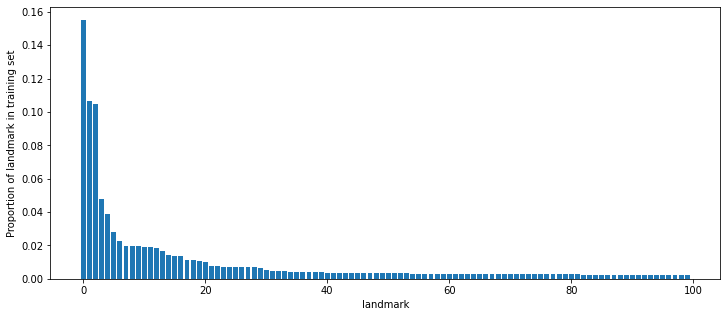

In [17]:
plt.figure(figsize = (12, 5))
fig = plt.bar(range(100), landmark_dist)
plt.xlabel("landmark")
plt.ylabel("Proportion of landmark in training set")
plt.savefig('class_dist.png')


In [18]:
landmark = train_df.landmark_id.value_counts()
landmark_df = pd.DataFrame({'landmark_id':landmark.index, 'frequency':landmark.values}).head(30)

landmark_df['landmark_id'] =   landmark_df.landmark_id.apply(lambda x: f'landmark_id_{x}')

fig = px.bar(landmark_df, x="frequency", y="landmark_id",color='landmark_id',
             hover_data=["landmark_id", "frequency"],
             height=1000,
             title='Number of images per landmark_id (Top 30 landmark_ids)',
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

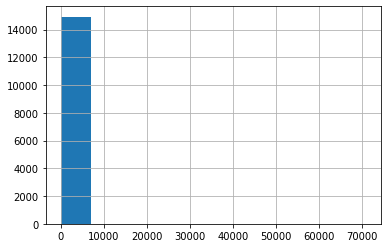

In [19]:
landmark.hist()

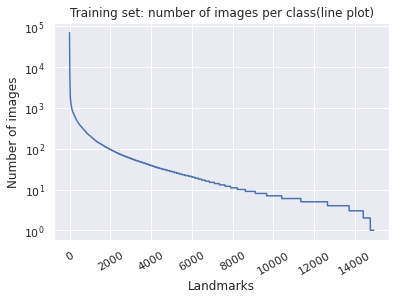

In [20]:
sns.set()
plt.title('Training set: number of images per class(line plot)')
sns.set_color_codes("pastel")
landmarks_fold = pd.DataFrame(train_df['landmark_id'].value_counts())
landmarks_fold.reset_index(inplace=True)
landmarks_fold.columns = ['landmark_id','count']
ax = landmarks_fold['count'].plot(logy=True, grid=True)
locs, labels = plt.xticks()
plt.setp(labels, rotation=30)
ax.set(xlabel="Landmarks", ylabel="Number of images")
plt.show()

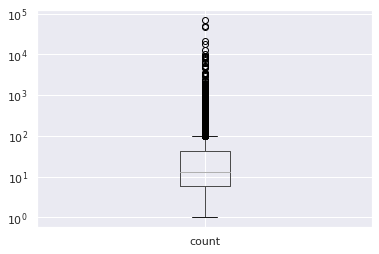

In [21]:
sns.set()
ax = landmarks_fold.boxplot(column='count')
ax.set_yscale('log')

In [22]:
landmark.describe().transpose()

count    14945.000000
mean        81.969154
std        889.183108
min          1.000000
25%          6.000000
50%         13.000000
75%         43.000000
max      70827.000000
Name: landmark_id, dtype: float64

In [23]:
train_df.isnull().sum()

id             0
url            0
landmark_id    0
dtype: int64

In [24]:
value_counts = train_df['landmark_id'].value_counts() # normalize=True returns relative frequency

freq_df = pd.DataFrame(value_counts)
freq_df.reset_index(inplace=True)
freq_df.columns = ['landmark_id','frequency']
freq_df

,landmark_id,frequency
0,None,70827
1,9633,48550
2,6051,47825
3,6599,21777
4,9779,17601
...,...,...
14940,4639,1
14941,4608,1
14942,11974,1
14943,6069,1


# random horizontal flip with 50% probability

In [25]:
def get_transform(train):
    transforms = []
    if train:
        
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [26]:
class GoogleLandmarks(Dataset):
    def __init__(self, df, transforms):
        self.df = df
        self.dim = (512, 512)
        self.transforms = transforms
        self.ids = np.unique(df['landmark_id'].values)
        self.ids_dic = {v:k for k,v in enumerate(self.ids)}
    
    def url_to_image(self, url, dim):
        try:
            resp = urllib.request.urlopen(url)
        except:
            return np.array([])
        image = np.asarray(bytearray(resp.read()), dtype="uint8")
        if(image.size != 0):
            image = cv2.imdecode(image, cv2.IMREAD_COLOR)
            image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
            image = Image.fromarray(np.uint8(image))
            if(image):
                image = self.transforms(image)
        else:
            image = Image.fromarray(image)
        return T.ToTensor()(image)
    
    def get_rect(self, boxes):
        try:
            y = boxes[0]
            x = boxes[1]
            h = boxes[2] - boxes[0]
            w = boxes[3] - boxes[1]
        except:
            return None
        return plt.Rectangle((x, y), w, h, color='y', alpha=0.3)
    
    def draw_bbox(self, img, rect):
        fig, ax = plt.subplots()
        plt.imshow(img.permute(1, 2, 0))
        if(rect):
            ax.add_patch(rect)
    
    def format_boxes(self, boxes, dim):
        return (np.array(boxes.split(' ')).astype(np.float32) * dim[0]).astype(np.int64)
    
    def __getitem__(self, idx):
        id = self.df.iloc[idx].id
        landmarkid = self.df.iloc[idx].landmark_id
        url = self.df[self.df.id == id].url.values[0]
        boxes = self.df[self.df.id == id].box.values[0]
        
        
        # format boxes
        boxes = self.format_boxes(boxes, self.dim)
        
        labels = np.eye(len(self.ids))[self.ids_dic[landmarkid]]
        
        target = {}
        target["boxes"] = torch.as_tensor([boxes], dtype=torch.int64)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        target["image_id"] = torch.tensor([idx])
        target["area"] = (boxes[3] - boxes[1]) * (boxes[2] - boxes[0])
        target["iscrowd"] = torch.zeros((1,), dtype=torch.int64)
        
        image = self.url_to_image(url, self.dim)
        
        if(len(image) == 0):
            return None, None
        
        return image, target
        
    def __len__(self):
        return len(self.ids)

In [27]:
# select 10 ids randomly
idxes = [randint(0, len(df_train) - 1) for i in range(10)]

# select only 10 landmarks
ids_of_landmarks = df_train['landmark_id'][idxes].values

# subset of training data with 10 landmarks
df = df_train[df_train['landmark_id'].isin(ids_of_landmarks)]

# google dataset
google_ds = GoogleLandmarks(df, get_transform(train=True))

In [28]:
image, target = google_ds[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)



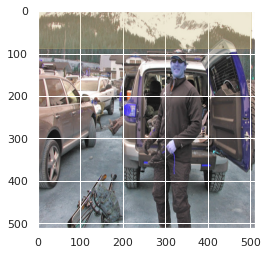

In [29]:
rect = google_ds.get_rect(target['boxes'][0])
google_ds.draw_bbox(image, rect)

In [30]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [31]:
data_loader = torch.utils.data.DataLoader(
        google_ds, batch_size=8, shuffle=True, num_workers=4,
        collate_fn=collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



In [32]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Model faster R-CNN Error Epoch

In [33]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [34]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [35]:
total_errors = []
for epoch in range(10):
    losses_arr = []

    for images, targets in data_loader:

        images = list(image.to(device) for image in images if image is not None)
        targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets if t is not None]

        optimizer.zero_grad()

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses_arr.append(losses.item())

        losses.backward()
        optimizer.step()

        # update the learning rate
        # lr_scheduler.step()
        
    total_errors.append(np.mean(np.array(losses_arr)))
    if epoch % 1 == 0:
        print("Epoch:{0:3d}, Loss:{1:1.3f}".format(epoch, total_errors[-1]))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)



Epoch:  0, Loss:0.582
Epoch:  1, Loss:0.474
Epoch:  2, Loss:0.266
Epoch:  3, Loss:0.158
Epoch:  4, Loss:0.115
Epoch:  5, Loss:0.089
Epoch:  6, Loss:0.041
Epoch:  7, Loss:0.057
Epoch:  8, Loss:0.046
Epoch:  9, Loss:0.031


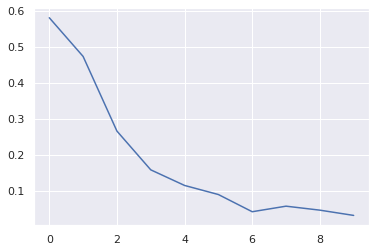

In [36]:
plt.plot(total_errors)

# Resnet 50

In [37]:
!pip install keras
!pip install Keras-Applications
from keras import applications


     |████████████████████████████████| 50 kB 2.9 MB/s 


In [38]:
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

In [40]:
model = ResNet50(weights='imagenet')


102981632/102967424 [==============================] - 1s 0us/step


In [41]:
model_cut = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [42]:
import csv
with open("train1.csv", "r", encoding="utf8") as f:
    train_set = [{k: v for k, v in row.items()} for row in csv.DictReader(f, skipinitialspace=True)] 

In [43]:
train_set[0]

{'id': '97c0a12e07ae8dd5',
 'landmark_id': '6347',
 'url': 'http://lh4.ggpht.com/-f8xYA5l4apw/RSziSQVaABI/AAAAAAAAASE/V8rWCdC0cvI/s1600/'}

# Preparing the images 

In [44]:
from PIL import Image
import io
import urllib

def get_image(URL):
    with urllib.request.urlopen(URL) as url:
        img = Image.open(io.BytesIO(url.read()))
        img = img.convert("RGB")
        img = img.resize((224, 224))
    return img

In [45]:
def preprocess_img(img): 
    x1 = image.img_to_array(img)
    x1 = x1[np.newaxis] 
    x1 = preprocess_input(x1)
    return x1

# Calculating embeddings for each monument

In [46]:
def pass_img_to_model(x):
    return model_cut.predict(x)

In [47]:
embeddings = []
for instance in tqdm(train_set[:1000]): 
    try:
        embeddings.append({"id": instance["id"], "url" : instance["url"], "embedding": pass_img_to_model(preprocess_img(get_image(instance["url"])))})
    except:
        pass

  0%|          | 0/1000 [00:00<?, ?it/s]

In [48]:
embeddings[0]

{'embedding': array([[0.16491775, 0.567014  , 0.00093975, ..., 0.3385824 , 0.07176723,
         0.06702463]], dtype=float32),
 'id': '97c0a12e07ae8dd5',
 'url': 'http://lh4.ggpht.com/-f8xYA5l4apw/RSziSQVaABI/AAAAAAAAASE/V8rWCdC0cvI/s1600/'}

# Find images with the same monuments

In [49]:
def find_most_similar_imgs(URL, seuil):
    similar_imgs = []
    
    vec_url = np.array(pass_img_to_model(preprocess_img(get_image(URL)))[0])
    vec_url = vec_url / np.linalg.norm(vec_url)
    
    for embedding in embeddings:
        vec_emb = np.array(embedding['embedding'][0])
        vec_emb = vec_emb / np.linalg.norm(vec_emb) 
        similarity = np.dot(vec_url, vec_emb)
        if similarity >= seuil:
            similar_imgs.append((embedding['url'],similarity))
    
    return similar_imgs

# Image reference


In [50]:
URL_REF = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/Colosseo_2020.jpg/1200px-Colosseo_2020.jpg"

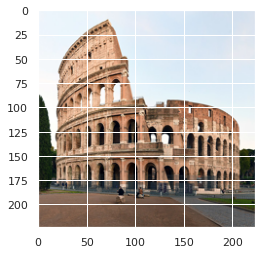

In [51]:
plt.imshow(get_image(URL_REF))

# We compare with all images

In [52]:
sim_things = find_most_similar_imgs(URL_REF ,0.7)
sim_things.sort(reverse = True, key = lambda x: x[1])

# Results

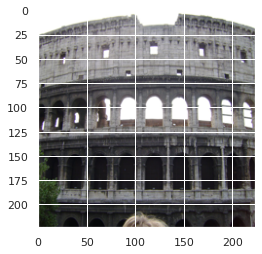

similarité:  0.75641847



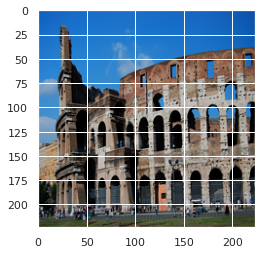

similarité:  0.7481578



In [53]:
import matplotlib.pyplot as plt
for url, val in sim_things:
    plt.imshow(get_image(url))
    plt.show()
    print("similarité: " ,val)
    print()

## Create train, validation and test dataset for Faster R-CNN

### Stratified sampling of training, validation and test dataset with 0.8, 0.4 and 0.1 split

In [54]:
from sklearn.model_selection import StratifiedShuffleSplit

X = train_sample_df['id']
y = train_sample_df['landmark_id']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=10)

for train_id, test_id in sss.split(X, y):
    X_train, X_tmp = X.iloc[train_id], X.iloc[test_id]
    y_train, y_tmp = y.iloc[train_id], y.iloc[test_id]

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.8, random_state=10)

for train_id, test_id in sss1.split(X_tmp, y_tmp):
    X_valid, X_test = X_tmp.iloc[train_id], X_tmp.iloc[test_id]
    y_valid, y_test = y_tmp.iloc[train_id], y_tmp.iloc[test_id]

## Benchmark Model (Random Guessing)
### Expected accuracy

In [55]:
from itertools import combinations

def expected_acc(prob_id):
    
    prob_id_c = 1 - prob_id
    prob_correct_number = []

    for i in range(len(prob_id)+1):

        id_comb = list(combinations(range(len(prob_id)), r=i))
        id_notcomb = [tuple(set(range(len(prob_id)))^set(x)) for x in id_comb]

        prob_comb = np.array([[prob_id[x] for x in id_comb[i]] for i in range(len(id_comb))])
        prob_notcomb = np.array([[prob_id_c[x] for x in id_notcomb[i]] for i in range(len(id_notcomb))])

        prob_num = np.hstack((prob_comb, prob_notcomb))
        ss = sum([np.prod(x) for x in prob_num])

        prob_correct_number.append(ss)

    expected_correct_num = sum(np.array(range(len(prob_id)+1)) * np.array(prob_correct_number))
    expected_accuracy = expected_correct_num / len(prob_id)
    
    return([expected_correct_num, expected_accuracy])

### Monte Carlo simulation of expected accuracy

In [56]:
import random

### Calculate probability of correctly classifying a landmark_id, P(id)

# prob_id = np.array([0.25, 0.1]) # Example tryout given the probability of two images

prob_id = np.array([(y_test == id).sum() / len(y_test) for id in y_test]) # Calculates probabilities of all landmark_id
seed = [3, 10, 27, 31, 48, 55, 67, 95, 105, 117]

expected_val_df = pd.DataFrame(columns=['E(x)', 'Accuracy'])

for i in seed:
    
    random.seed(i)
    randsample = random.sample(range(len(y_test)), 20)
    
    prob_id_montecarlo = prob_id[randsample]  # random selection of 20 images (instead of total test dataset)
    expected_val_df.loc[len(expected_val_df)] = expected_acc(prob_id_montecarlo)

In [57]:
expected_val_df

,E(x),Accuracy
0,0.780780,0.039039
1,0.650821,0.032541
2,1.521204,0.076060
3,0.786594,0.039330
4,1.154583,0.057729
5,1.084815,0.054241
6,0.971614,0.048581
7,1.176471,0.058824
8,1.261970,0.063098
9,1.223666,0.061183


In [58]:
round(expected_val_df.T,3)

,0,1,2,3,4,5,6,7,8,9
E(x),0.781,0.651,1.521,0.787,1.155,1.085,0.972,1.176,1.262,1.224
Accuracy,0.039,0.033,0.076,0.039,0.058,0.054,0.049,0.059,0.063,0.061


In [59]:
expected_val_df.mean()

E(x)        1.061252
Accuracy    0.053063
dtype: float64

In [60]:
import os
from keras.preprocessing import image                  
from tqdm import tqdm

img_shape = (192, 256) # Image shape (height, width)

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=img_shape)
    
    # convert PIL.Image.Image type to 3D tensor with shape (192, 256, 3)
    x = image.img_to_array(img)
    
    # convert 3D tensor to 4D tensor with shape (1, 192, 256, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [61]:
from glob import glob
import os

# define function to load train, test, and validation datasets
train_path = './train_images/'
valid_path = './valid_images/'
test_path = './test_images/'

def load_dataset(path, train_sample):
    file_out = sorted(glob(path + '*'))
    file_out = np.array([s.replace("\\", "/") for s in file_out])
    
    label_out = pd.Series(name="landmark_id")
    
    for file in file_out:
        filebase = os.path.basename(file)
        name = os.path.splitext(filebase)[0]
        temp = train_sample.landmark_id[train_sample["id"] == name]
        label_out = label_out.append(temp)
        
    label_out = np.array(pd.get_dummies(label_out))
    
    return file_out, label_out

In [62]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [63]:
input_shape = img_shape + (3,)

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=4, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(100, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 256, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 128, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 128, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 32, 64)       0

In [64]:
## Model Evaluation for Faster R-CNN 

In [65]:
hist_BaseCNN = {'acc': [0.13132716049382717, 0.17654320987654321, 0.22330246913580246, 0.28456790123456788, 0.36003086419753089,
                        0.44645061728395063, 0.54243827160493829, 0.65416666666666667, 0.75169753086419755, 0.8246913580246914],
                'loss': [3.9298892386165667, 3.680104664814325, 3.3804817258575817, 3.066348374920127, 2.6730856707066666,
                         2.2241253917599901, 1.7646778118463211, 1.286705630502583, 0.87414459122551813, 0.60244603024588694],
                'val_acc': [0.17142857183580812, 0.19751552835754727, 0.24472049730164663, 0.29565217420921563,
                            0.37391304407060516, 0.3913043485294958, 0.43229813649787668, 0.4211180122742742,
                            0.42484472160753994, 0.41987577687879529],
                'val_loss': [3.7763777463332469, 3.5307922268506164, 3.2851792984127259, 2.9763647654041741, 2.737886569514778,
                             2.6325608985024211, 2.5756296847918021, 2.7493783006016512, 2.8917108950407608,3.2256962965734255]}

In [66]:
hist_BaseCNN_df = pd.DataFrame(hist_BaseCNN)
hist_BaseCNN_df.columns = ['Train_acc', 'Train_loss', 'Val_acc','Val_loss']
hist_BaseCNN_df

,Train_acc,Train_loss,Val_acc,Val_loss
0,0.131327,3.929889,0.171429,3.776378
1,0.176543,3.680105,0.197516,3.530792
2,0.223302,3.380482,0.244720,3.285179
3,0.284568,3.066348,0.295652,2.976365
4,0.360031,2.673086,0.373913,2.737887
5,0.446451,2.224125,0.391304,2.632561
6,0.542438,1.764678,0.432298,2.575630
7,0.654167,1.286706,0.421118,2.749378
8,0.751698,0.874145,0.424845,2.891711
9,0.824691,0.602446,0.419876,3.225696


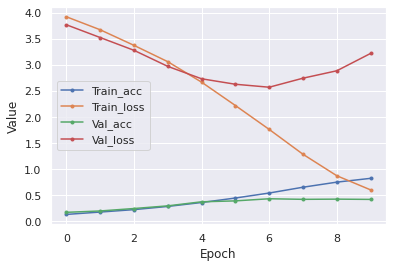

In [67]:
ax1 = hist_BaseCNN_df.plot(marker='.')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Value")
plt.savefig('base.png')

In [68]:
hist_Aug1 = {'acc': [0.25546875000000002, 0.29408060445893619, 0.30462846340100169, 0.33674433294411571, 0.34146725470833572,
                     0.35941435768261965, 0.35925692687707222, 0.38365868995111596, 0.38727959705239878, 0.40192065483676997,
                     0.4208123424191319, 0.42191435753248202, 0.43938916906601838, 0.45560453385490013, 0.46221662491034499,
                     0.46300377878794441, 0.49071158705190088, 0.48598866498740556, 0.50519521410579349, 0.51243702770780852,
                     0.51338161254109305, 0.53494962246652211, 0.5469143573823444, 0.54738665017433075, 0.54707178841309823,
                     0.55919395450981202, 0.57761335027608218, 0.58705919470534818, 0.58658690161308658, 0.59382871551537697,
                     0.60862720418036431, 0.61319269506396812, 0.60799748125844999, 0.62043450881612094, 0.61791561727860111,
                     0.62641687627403198, 0.63082493747812074, 0.6460957172835804, 0.650818640098764, 0.64798488710028701,
                     0.6527078087143694, 0.66593198977429557, 0.67726700341971757, 0.67742443324937029, 0.67333123395665162,
                     0.67553526448362722, 0.68246221707509802, 0.69285264483627207, 0.7029282120373147, 0.69899244302466179,
                     0.71630982307703128, 0.6985201511335013, 0.71048488634959872, 0.71656249999999999, 0.71505037813402839,
                     0.71977329974811088, 0.7282745596443676, 0.73646095747911655, 0.73803526478390247, 0.75409319944285624],
             'loss': [3.2232321786880491, 2.9990468968071924, 2.9238310268603884, 2.7992355565280098, 2.737023192028555,
                      2.6451771565588658, 2.6298042989197548, 2.5292290740409484, 2.4872682490937357, 2.4218320276034571,
                      2.3226811627596993, 2.299093459655416, 2.2177092599628554, 2.2043386424518654, 2.1157339285843317,
                      2.0904880164552395, 2.0064047355795989, 1.9939596881193837, 1.9514757896250381, 1.9008020567954036,
                      1.876178127392113, 1.782965435489299, 1.7345330483967472, 1.7294392582751641, 1.7163397094764998,
                      1.6662033177743329, 1.6024818057077057, 1.5661355632378413, 1.5691469054978802, 1.5227450225455335,
                      1.469195683597017, 1.4539444128271914, 1.4576934302784033, 1.4022760595422548, 1.3867993583006581,
                      1.3635792876370909, 1.3296321273150311, 1.2845476106071954, 1.265174487676068, 1.2719144436814622,
                      1.2758843298222615, 1.2146366297147737, 1.1755962930338208, 1.163139341460067, 1.1503687775705562,
                      1.1531679134825314, 1.1188850982363339, 1.0898135984574517, 1.0535212247738008, 1.0678208411790862,
                      1.0192861403866438, 1.0809404141356422, 1.0331504585160416, 0.98859515905380246, 1.00419298527523,
                      0.99700506358062591, 0.96955797684282741, 0.93192633513539502, 0.91039594775183075, 0.87640107939165246],
             'val_acc': [0.3828125, 0.39438700367816265, 0.39881831830150094, 0.41802068092094036, 0.44313146339033344,
                         0.46233382715432297, 0.4357459379175741, 0.45963541666666669, 0.49778434414102901, 0.46971935113036301,
                         0.48596750562969304, 0.50516986899749217, 0.50516986987791523, 0.56129985396231652,0.54036458333333337,
                         0.52437223298158742, 0.52732644299460651, 0.55096012248246318, 0.5509601204574901, 0.57607090182635423,
                         0.56129985721988196, 0.5703125, 0.58345642646271156, 0.60265879071093376, 0.58345642646271156,
                         0.59084195171536513, 0.60856720959242194, 0.59379616120013035, 0.62239583333333337,0.64106351806282824,
                         0.61595273519724481, 0.64254062117642807, 0.61742983654999839, 0.66469719640613478,
                         0.62629246579667486, 0.62630208333333337, 0.64844904129050862, 0.63810930505637053,
                         0.62924667906725951, 0.673559824420219, 0.6528803561779738, 0.64401772605087415, 0.65625,
                         0.64254062267314738, 0.63515509856504382, 0.64844904155463556, 0.66322008880237704, 0.6661743015447078,
                         0.68537666227123761, 0.65625, 0.66322008941867328, 0.68094534703160314, 0.67355982265937275,
                         0.70162481439342528, 0.68833087492552603, 0.68389955678049541, 0.68489583333333337, 0.692762186643468,
                         0.68537666517663387, 0.67651403478540728],
             'val_loss': [2.6452309290568032, 2.5847700216217264, 2.4060148689208036, 2.3356332831756053, 2.3420486395609079,
                          2.3017310786282472, 2.3716619233084923, 2.2140320539474487, 2.0899026453759153, 2.1580345694036218,
                          2.0487872564634158, 2.0332463872309448, 2.0096049868725956, 1.9020438509466377, 1.9020523428916931,
                          1.8518806903717966, 1.7829044162786869, 1.8370949434917117, 1.845528794180167, 1.7594302035152825,
                          1.8055269017353368, 1.6822096308072407, 1.7357862992335986, 1.6300792472225172, 1.7285163599772151,
                          1.6977536676553362, 1.6085897534425362, 1.6361149172663161, 1.5901709794998169, 1.484190075929267,
                          1.5790710727432453, 1.5120298226791788, 1.4797959715964346, 1.4832501860453775, 1.5785681849216253,
                          1.554775059223175, 1.4138278459340465, 1.3956891520160692, 1.5429726955281402, 1.3938687219225321,
                          1.4762555027994131, 1.4691717006607281, 1.4483438928922017, 1.4830871012221412, 1.4592810141987427,
                          1.4282475282029528, 1.425352577796891, 1.337258996780373, 1.3461823303202936, 1.4805522759755452,
                          1.3543041685659389, 1.2878402416075703, 1.391042958510327, 1.3276069699573376, 1.279264172035623,
                          1.3356382948961356, 1.367376983165741, 1.3885350897357946, 1.4288017251466896, 1.3429765403710934]}

In [69]:
hist_Aug1_df = pd.DataFrame(hist_Aug1)
hist_Aug1_df.columns = ['Test_acc', 'Test_loss', 'Val_acc','Val_loss']
hist_Aug1_df.head()

,Test_acc,Test_loss,Val_acc,Val_loss
0,0.255469,3.223232,0.382812,2.645231
1,0.294081,2.999047,0.394387,2.584770
2,0.304628,2.923831,0.398818,2.406015
3,0.336744,2.799236,0.418021,2.335633
4,0.341467,2.737023,0.443131,2.342049


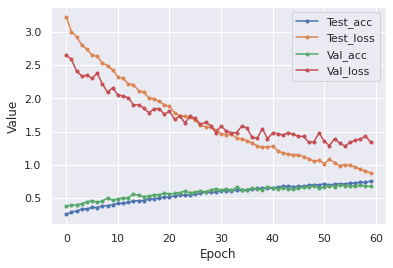

In [70]:
ax2 = hist_Aug1_df.plot(marker='.')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Value")
plt.savefig('aug.png')